# PREDICTION DES RETARDS DE VOL

---

## 1. IMPORT DES LIBRAIRIES

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from skimpy import skim

---

## 2. CHARGEMENT DES DONNÉES

Nos données sont réparties dans plusieurs fichiers. Nous allons donc, dans un premier temps, travailler avec le premier fichier "2016_01.csv" afin de mieux comprendre et analyser nos données.

Dans un second temps, nous déterminerons s’il est nécessaire ou pertinent de travailler avec les autres fichiers.

**Chargement des dataset

In [2]:
pd.set_option('display.max_rows', 65)
pd.set_option('display.max_columns', 65)

dfs = []

for month in range(1, 13):
    file = f"data/2016_{month:02}.csv"
    try:
        tmp = pd.read_csv(file, on_bad_lines='warn', low_memory=False)
        dfs.append(tmp)
        print(f"Loaded {file} ✅")
    except pd.errors.ParserError as e:
        print(f"ParserError for {file}: {e}")
    print("-" * 50)



Loaded data/2016_01.csv ✅
--------------------------------------------------
Loaded data/2016_02.csv ✅
--------------------------------------------------
Loaded data/2016_03.csv ✅
--------------------------------------------------


/tmp/ipykernel_250166/3836829173.py:9: ParserWarning: Skipping line 121012: expected 65 fields, saw 75
Skipping line 386249: expected 65 fields, saw 83
Skipping line 388291: expected 65 fields, saw 78
Skipping line 389371: expected 65 fields, saw 72
Skipping line 389548: expected 65 fields, saw 81
Skipping line 453858: expected 65 fields, saw 97

  tmp = pd.read_csv(file, on_bad_lines='warn', low_memory=False)


Loaded data/2016_04.csv ✅
--------------------------------------------------
Loaded data/2016_05.csv ✅
--------------------------------------------------
Loaded data/2016_06.csv ✅
--------------------------------------------------
Loaded data/2016_07.csv ✅
--------------------------------------------------
Loaded data/2016_08.csv ✅
--------------------------------------------------
Loaded data/2016_09.csv ✅
--------------------------------------------------
Loaded data/2016_10.csv ✅
--------------------------------------------------
Loaded data/2016_11.csv ✅
--------------------------------------------------
Loaded data/2016_12.csv ✅
--------------------------------------------------


In [3]:
data = pd.concat(dfs, ignore_index=True)

In [4]:
# stratify permet de préserver la distribution de la variable cible
data_clean = data.dropna(subset=['ARR_DEL15'])

df_sample, _ = train_test_split(data_clean, train_size=0.1, stratify=data_clean['ARR_DEL15'], random_state=42)

In [5]:
# skim(df_sample)

---

## 3. EXPLORATION DES DONNÉES

### Objectif :
- Comprendre du mieux possible nos données
- Développer une première stratégie de modélisation 

### Analyse de Forme :
- **Variable target** : ARR_DEL15 
- **Lignes et colonnes** : 445827 lignes et 65 colonnes
- **Types de variables** : Qualitatives : 50, Quantitatives : 15
- **Analyse des valeurs manquantes** :
  - Le dataset est plutot complet. Il y assez peu de valeurs NaN.
  - Seulement 10 colonnes sur 65 ne pourrons pas être utilisés car taux de NaN supérieur à 90%

### Analyse de Fond :
- **Visualisation de la target** :
  - 16% d'avions en retard (70882 / 433298)

- **Signification des variables** :
  Variables clés :
  - DEP_DELAY, ARR_DELAY, DEP_DEL15, ARR_DEL15 : mesures principales du retard.
  - CANCELLED, DIVERTED : indicateurs d'événements exceptionnels.
  - DEP_TIME_BLK, ARR_TIME_BLK : plages horaires normalisées utiles pour catégoriser le trafic.
  - UNIQUE_CARRIER, ORIGIN, DEST : identifiants des opérateurs et des lieux, souvent déséquilibrés.

- **Relation Variables / Target** :
  - DEP_DELAY, DEP_DEL15 : Très forte corrélation : un retard au départ mène souvent à un retard à l’arrivée.
  - DEP_DELAY_GROUP : Même logique : plus le groupe est élevé, plus la proba de ARR_DEL15 = 1 augmente.
  - ARR_DELAY / ARR_DELAY_NEW : Directement liées, mais inutilisables comme features (elles sont postérieures à l’arrivée).
  - CANCELLED, DIVERTED : Peu de cas, mais à exclure ou à gérer car ils biaisent la target (pas d'arrivée réelle)
  - DEP_TIME_BLK, ARR_TIME_BLK : Certaines heures de la journée sont plus sujettes aux retards (ex : pics de trafic).
  - DISTANCE, DISTANCE_GROUP : Les longs vols ont plus de chances de retard (mais pas toujours).
  - AIRLINE_ID, UNIQUE_CARRIER : Certaines compagnies ont plus de retards que d'autres (ex : low cost).
  - ORIGIN, DEST : Certains aéroports (ex : hubs encombrés) génèrent plus de retard.

- **NaN analyse** : 
  - Présence de valeurs manquantes dans : ARR_TIME, ARR_DELAY, WHEELS_ON, TAXI_IN, souvent liées à des vols annulés ou détournés

### Hypotheses : 

- ✅ H1 : Retards selon la plage horaire de départ (DEP_TIME_BLK)
- ✅ H2 : Retard au départ → retard à l’arrivée (DEP_DELAY vs ARR_DELAY)
- ✅ H3 : Taux de retard par compagnie (UNIQUE_CARRIER)
- ✅ H4 : Taux de retard par aéroport d’origine (ORIGIN)
- ✅ H5 : Taux de retard selon plage horaire d’arrivée (ARR_TIME_BLK)
- ❌ H6 : Plus la distance d’un vol est grande, plus il a de risques d’être en retard (DISTANCE_GROUP)

---

### Analyse de la forme des données

On fait une copie de notre dataset pour conserver le jeu de données initial sous la main

In [6]:
df = df_sample.copy()

On commence par regarder les dimensions de notre dataset

In [7]:
df.shape

(555619, 65)

Nous avons donc : 
- 65 colonnes
- 445827 lignes.

---

Ensuite on regarde le type de nos données

In [8]:
df.dtypes.value_counts

<bound method IndexOpsMixin.value_counts of YEAR                      object
QUARTER                   object
MONTH                      int64
DAY_OF_MONTH              object
DAY_OF_WEEK               object
FL_DATE                   object
UNIQUE_CARRIER            object
AIRLINE_ID                 int64
CARRIER                   object
TAIL_NUM                  object
FL_NUM                    object
ORIGIN_AIRPORT_ID         object
ORIGIN_AIRPORT_SEQ_ID      int64
ORIGIN_CITY_MARKET_ID     object
ORIGIN                    object
ORIGIN_CITY_NAME          object
ORIGIN_STATE_ABR          object
ORIGIN_STATE_FIPS        float64
ORIGIN_STATE_NM           object
ORIGIN_WAC                object
DEST_AIRPORT_ID           object
DEST_AIRPORT_SEQ_ID       object
DEST_CITY_MARKET_ID       object
DEST                      object
DEST_CITY_NAME            object
DEST_STATE_ABR            object
DEST_STATE_FIPS          float64
DEST_STATE_NM             object
DEST_WAC                 float64

<Axes: ylabel='count'>

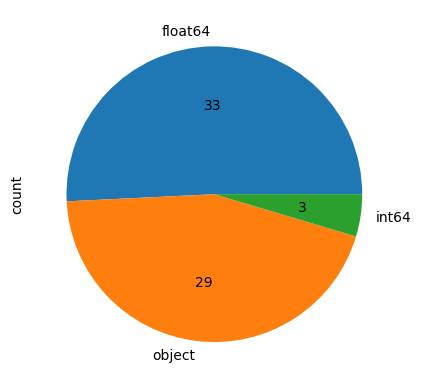

In [9]:
df.dtypes.value_counts().plot.pie(autopct=lambda p: '{:.0f}'.format(p * df.dtypes.value_counts().sum() / 100))

Nous avons donc 
- Qualitatives : (30 + 20) = 50
- Quantitatives : 15

---

On regarde maintenant le taux de valeurs manquantes dans notre dataset à l'aide d'une heatmap

<Axes: >

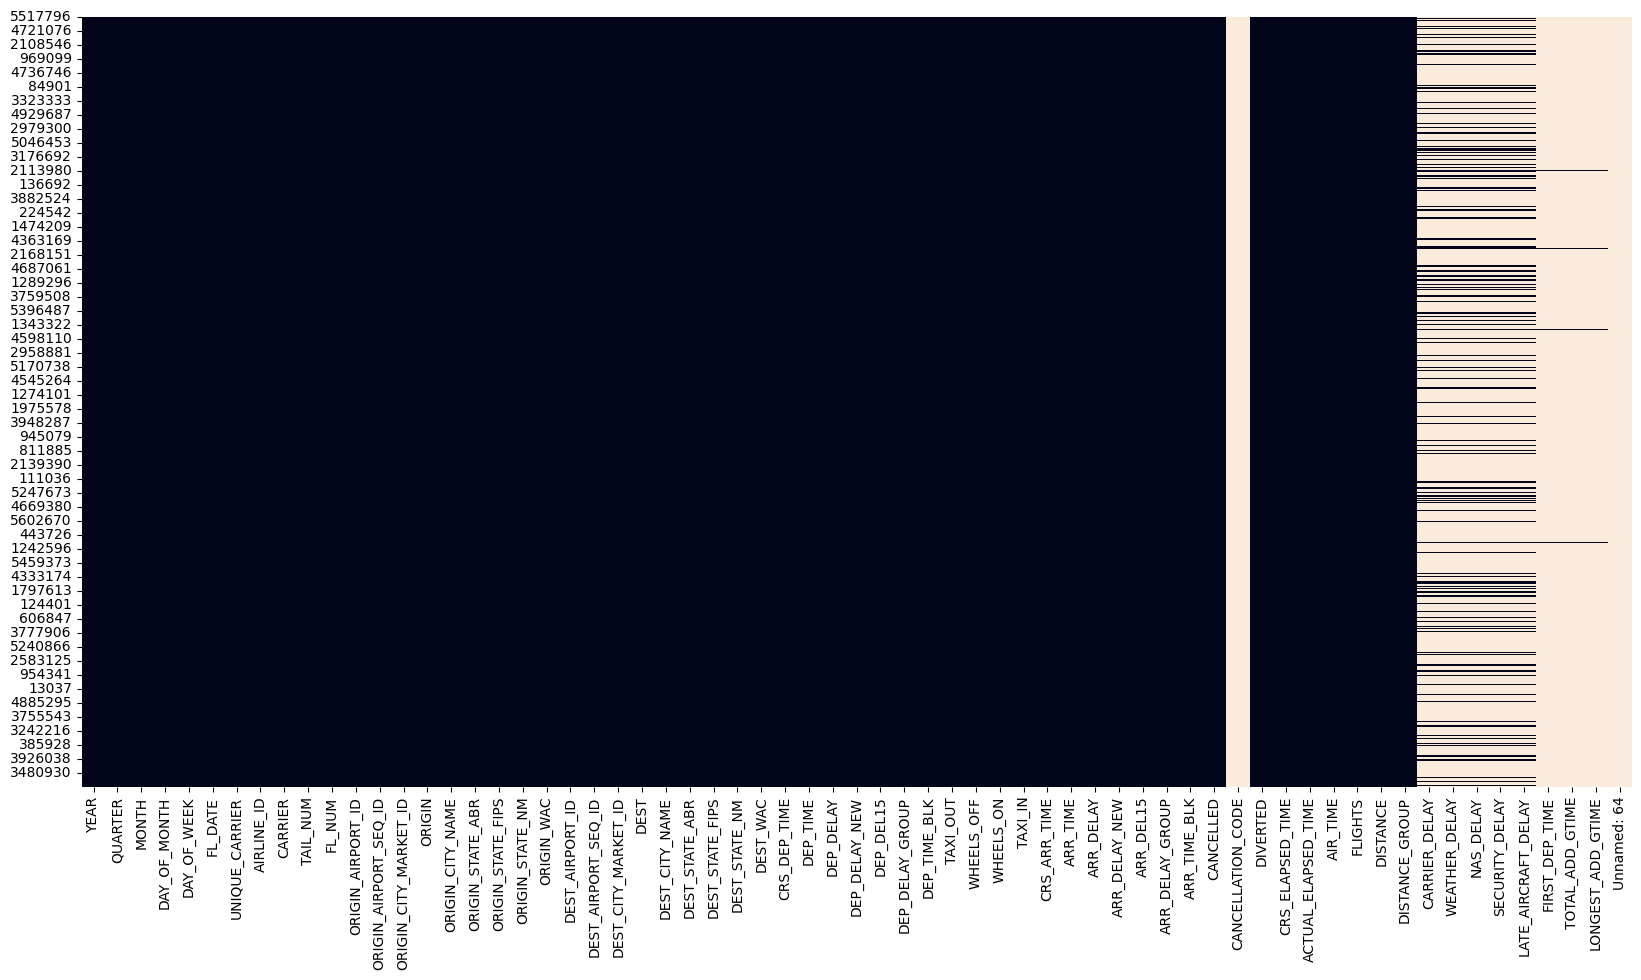

In [10]:
plt.figure(figsize=(20,10))
sns.heatmap(df.isna(), cbar=False)

In [11]:
(df.isna().sum()/df.shape[0]).sort_values(ascending=True)

YEAR                     0.000000
QUARTER                  0.000000
MONTH                    0.000000
DAY_OF_MONTH             0.000000
DAY_OF_WEEK              0.000000
FL_DATE                  0.000000
UNIQUE_CARRIER           0.000000
AIRLINE_ID               0.000000
CARRIER                  0.000000
TAIL_NUM                 0.000000
FL_NUM                   0.000000
ORIGIN_AIRPORT_ID        0.000000
ORIGIN_AIRPORT_SEQ_ID    0.000000
ORIGIN_CITY_MARKET_ID    0.000000
ORIGIN                   0.000000
ORIGIN_CITY_NAME         0.000000
ORIGIN_STATE_ABR         0.000000
ORIGIN_STATE_FIPS        0.000000
ORIGIN_STATE_NM          0.000000
ORIGIN_WAC               0.000000
DEST_AIRPORT_ID          0.000000
DEST_AIRPORT_SEQ_ID      0.000000
DEST_CITY_MARKET_ID      0.000000
DEST                     0.000000
DEST_CITY_NAME           0.000000
DEST_STATE_ABR           0.000000
DEST_STATE_FIPS          0.000000
DEST_STATE_NM            0.000000
DEST_WAC                 0.000000
CRS_DEP_TIME  

On peut voir ici 3 groupes de données
- Données manquantes 80 % et plus
- Données manquantes 25% - 30 %
- Données manquantes 0% - 1 %

---

## 4. VISUALISATIONS

### Analyse de fond

On retire les colonnes qui ont un taux de NaN > 80%

In [12]:
df = df[df.columns[df.isna().sum()/df.shape[0] <0.8]]

Après analyse de chaque colonne, il s'avère que certaines informations soient sensibles :
- TAIL_NUM : Peut identifier un avion précis, donc risque de traçage. 
- FL_NUM : Le numéro du vol peut être ok, mais couplé à date + compagnie → risque d’identification précise.

On fait donc le choix de les retirer de notre dataset

In [13]:
df = df.drop('TAIL_NUM', axis=1)
df = df.drop('FL_NUM', axis=1)

In [14]:
df.head()

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,UNIQUE_CARRIER,AIRLINE_ID,CARRIER,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_ABR,ORIGIN_STATE_FIPS,ORIGIN_STATE_NM,ORIGIN_WAC,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST_CITY_MARKET_ID,DEST,DEST_CITY_NAME,DEST_STATE_ABR,DEST_STATE_FIPS,DEST_STATE_NM,DEST_WAC,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,DEP_DELAY_NEW,DEP_DEL15,DEP_DELAY_GROUP,DEP_TIME_BLK,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,ARR_DELAY_NEW,ARR_DEL15,ARR_DELAY_GROUP,ARR_TIME_BLK,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,FLIGHTS,DISTANCE,DISTANCE_GROUP
5517796,2016,4,12,23,5,2016-12-23,VX,21171,VX,13830,1383002,33830,OGG,"Kahului, HI",HI,15.0,Hawaii,2,14771,1477102,32457,SFO,"San Francisco, CA",CA,6.0,California,91.0,2310.0,5.0,55.0,55.0,1.0,3.0,2300-2359,12.0,17.0,648.0,6.0,615.0,654.0,39.0,39.0,1.0,2.0,0600-0659,0.0,0.0,305.0,289.0,271.0,1.0,2338.0,10.0
3481010,2016,3,8,22,1,2016-08-22,DL,19790,DL,10792,1079204,30792,BUF,"Buffalo, NY",NY,36.0,New York,22,10397,1039705,30397,ATL,"Atlanta, GA",GA,13.0,Georgia,34.0,1620.0,1636.0,16.0,16.0,1.0,1.0,1600-1659,13.0,1649.0,1826.0,6.0,1830.0,1832.0,2.0,2.0,0.0,0.0,1800-1859,0.0,0.0,130.0,116.0,97.0,1.0,712.0,3.0
1277302,2016,1,3,9,3,2016-03-09,AA,19805,AA,11057,1105703,31057,CLT,"Charlotte, NC",NC,37.0,North Carolina,36,14122,1412202,30198,PIT,"Pittsburgh, PA",PA,42.0,Pennsylvania,23.0,1635.0,1631.0,-4.0,0.0,0.0,-1.0,1600-1659,19.0,1650.0,1747.0,6.0,1802.0,1753.0,-9.0,0.0,0.0,-1.0,1800-1859,0.0,0.0,87.0,82.0,57.0,1.0,366.0,2.0
3107908,2016,3,7,26,2,2016-07-26,DL,19790,DL,10397,1039705,30397,ATL,"Atlanta, GA",GA,13.0,Georgia,34,14730,1473003,33044,SDF,"Louisville, KY",KY,21.0,Kentucky,52.0,2116.0,2204.0,48.0,48.0,1.0,3.0,2100-2159,10.0,2214.0,2301.0,4.0,2239.0,2305.0,26.0,26.0,1.0,1.0,2200-2259,0.0,0.0,83.0,61.0,47.0,1.0,321.0,2.0
725113,2016,1,2,15,1,2016-02-15,EV,20366,EV,11298,1129804,30194,DFW,"Dallas/Fort Worth, TX",TX,48.0,Texas,74,14814,1481402,30476,SHV,"Shreveport, LA",LA,22.0,Louisiana,72.0,1515.0,1641.0,86.0,86.0,1.0,5.0,1500-1559,13.0,1654.0,1724.0,2.0,1612.0,1726.0,74.0,74.0,1.0,4.0,1600-1659,0.0,0.0,57.0,45.0,30.0,1.0,190.0,1.0


---

### Examen de la colonne target

In [15]:
df['ARR_DEL15'].value_counts()

ARR_DEL15
0.0    458775
1.0     96844
Name: count, dtype: int64

In [16]:
df['ARR_DEL15'].value_counts(normalize=True)

ARR_DEL15
0.0    0.825701
1.0    0.174299
Name: proportion, dtype: float64

On remarque ici que notre colonne target comporte 70 882 avions en retard

---

### Histogrames des variables continues


#### Variable quantitatives

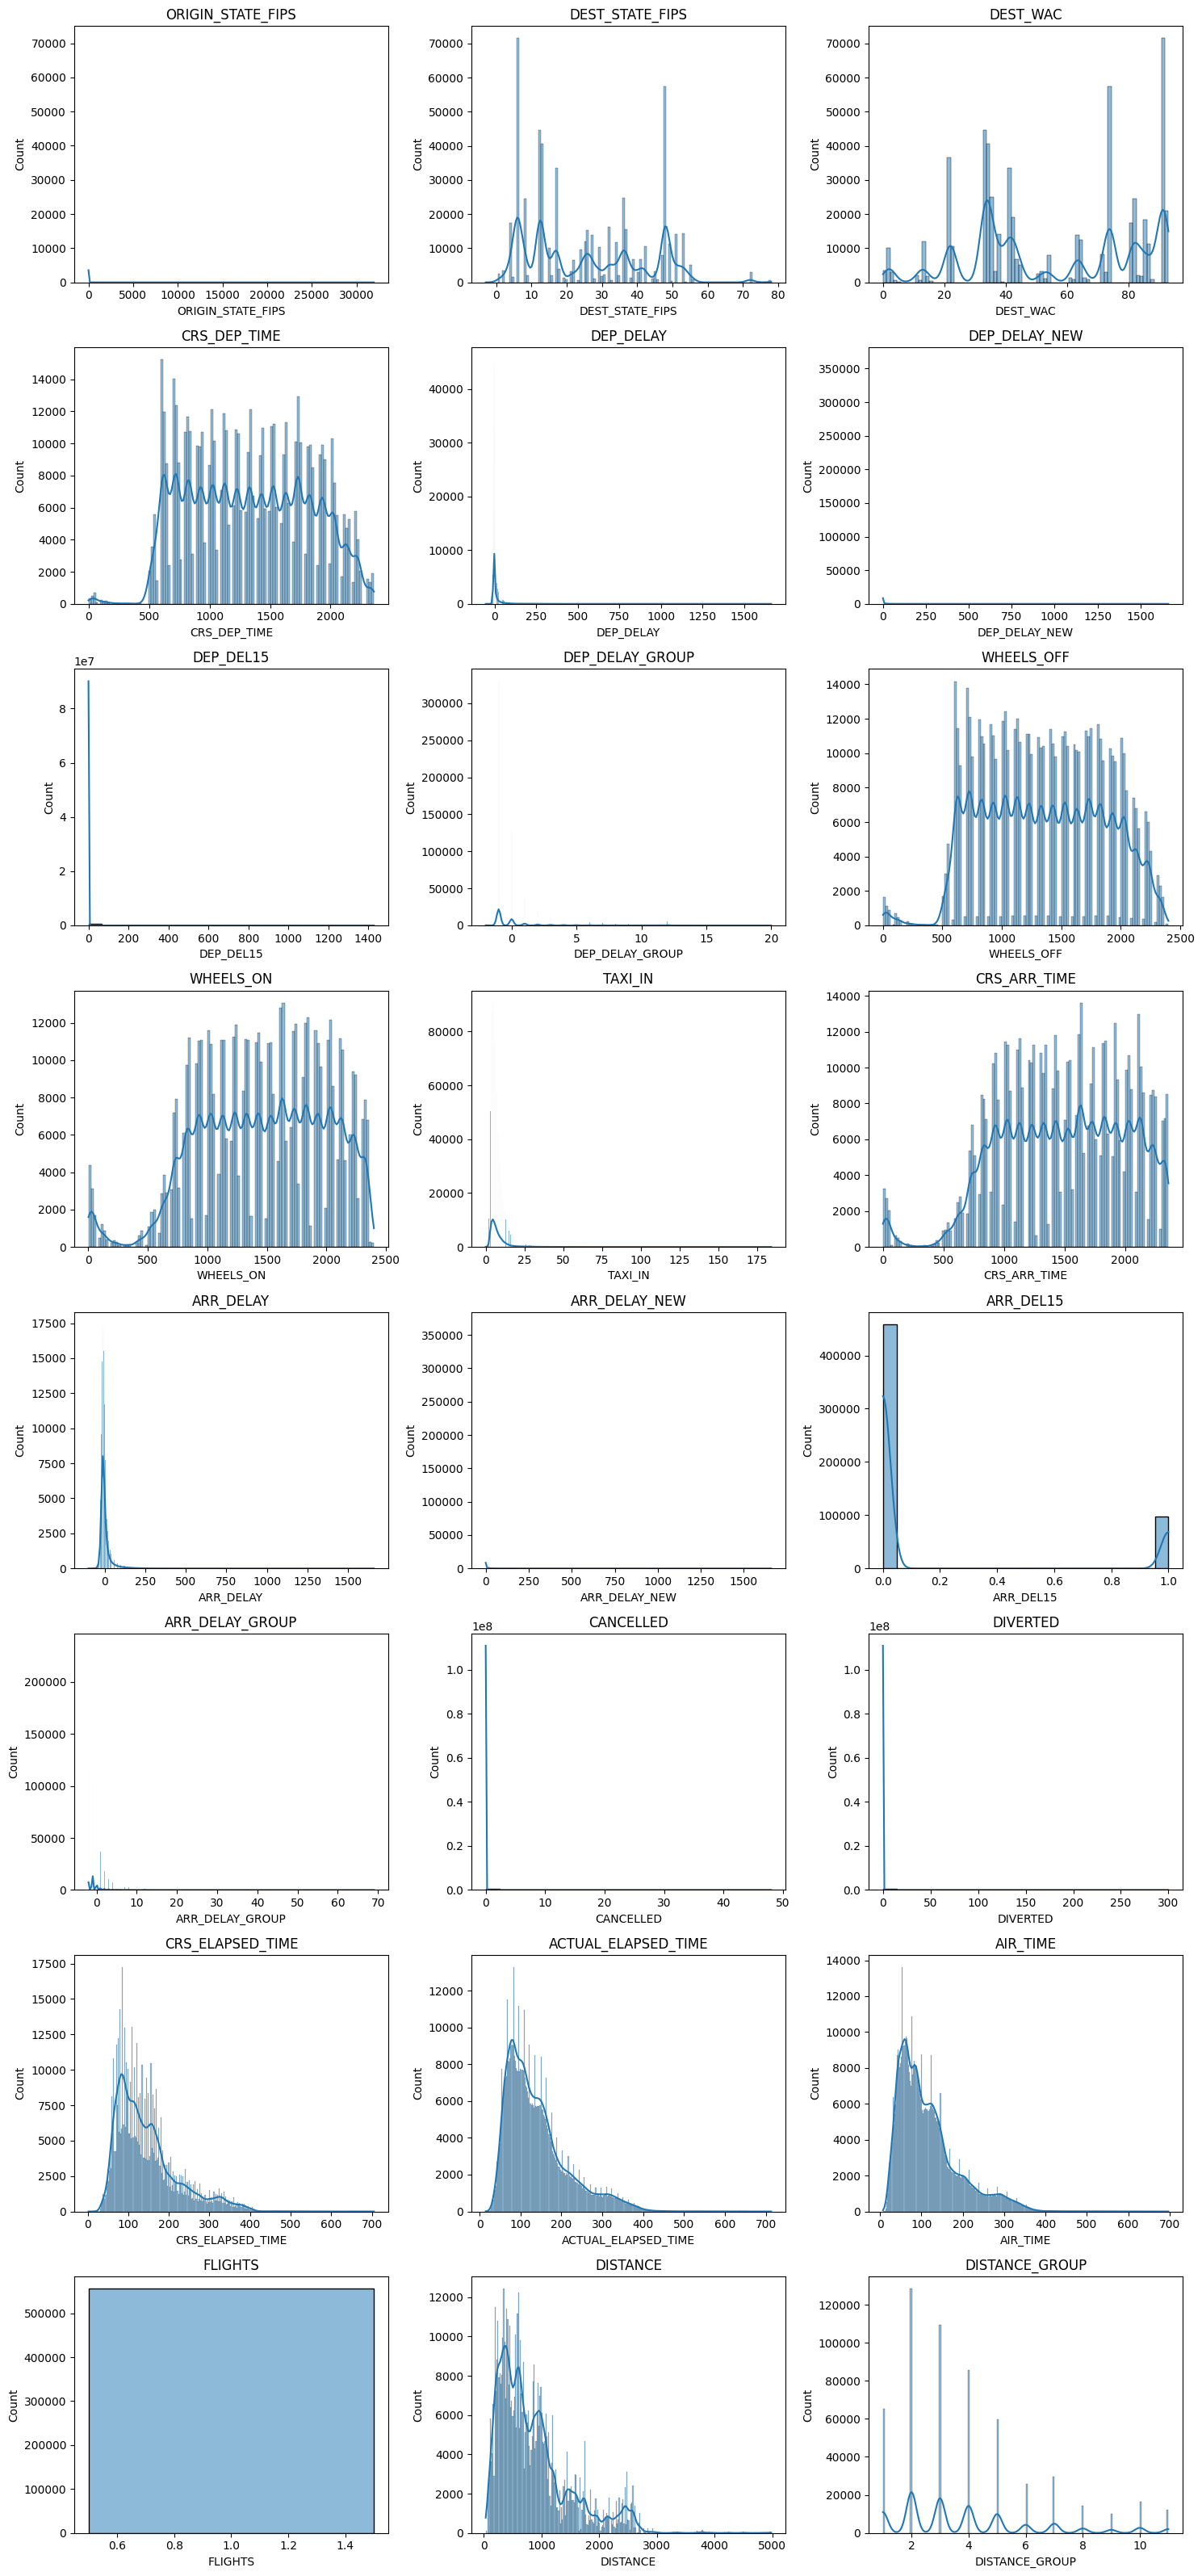

In [17]:
# Select float columns only
float_cols = df.select_dtypes('float').columns

# Set cols per row
n_cols = 3

# Compute necessary row
n_rows = -(-len(float_cols) // n_cols)

# Set grid
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))

# Aplatis l'objet axes si besoin
axes = axes.flatten()

# Loop on each axes and columns
for ax, col in zip(axes, float_cols):
    sns.histplot(df[col], ax=ax, kde=True)
    ax.set_title(col)

plt.tight_layout()
plt.show()

#### Analyses des histogrames

DEP_TIME : 

- La majorité des vols partent entre 500 (5h00) et 2100 (21h00).
- On voit des pics réguliers, cela reflète souvent des plages horaires avec plus de départs programmés (par ex. tôt le matin et fin d’après-midi).
- Le creux entre minuit et 5h00 montre qu’il y a très peu de départs de nuit.

DEP_DELAY : 

- Un pic très marqué autour de 0 indique que beaucoup de vols partent à l’heure ou presque.
- Très peu de vols ont un retard important (au-delà de 100, 200 min, etc.).
- Certains retards extrêmes (> 1000 min) existent mais très rares.

DEP_DEL15 : 

- Variable binaire : indique si le vol a eu un retard ≥ 15 min au départ.
  - 0 = pas de retard significatif
  - 1 = retard ≥ 15 min

- La majorité des vols sont à 0, la plupart n’ont pas eu de gros retard au départ.

DEP_DELAY_GROUP : 

- Variable catégorisant le retard au départ en groupes d’intervalles.
- Pic important vers 0 ou 1, beaucoup de vols à l’heure ou avec peu de retard

TAXI_OUT :

- Temps de roulage entre la porte et la piste avant le décollage (en minutes)
- La majorité des avions roulent moins de 30 min. quelques cas extrêmes de roulage long (> 60 min).

WHEELS_OFF : 

- Heure du décollage réel (roues quittant la piste)
- Pics aux heures de pointe, creux la nuit ou tôt le matin.

WHEELS_ON : 

- Temps de roulage après atterrissage jusqu’à la porte (en minutes).
- Concentration autour de 5–20 min, la plupart des avions rejoignent leur porte rapidement

ARR_TIME : 

- Heure réelle d’arrivée à la porte 
- reflète les plages horaires d’activité des vols (comme WHEELS_ON)

ARR_DELAY : 

- Retard d’arrivée réel (en minutes)
- La majorité est proche de zéro, vols arrivant à l’heure ou sont peu retardés.
- Distribution asymétrique (quelques retards importants).

ARR_DELAY_NEW : 

- Version ajustée du retard d’arrivée (ARR_DELAY) mais sans valeurs négatives
- Pic marqué à zéro, montre tous les vols arrivés en avance ou à l’heure.
- Ensuite, distribution décroissante des retards

ARR_DEL15 :

- La grande majorité des vols n'ont pas eu de retard ≥15 min (valeur 0). Une minorité en a eu (valeur 1).
- variable cible

ARR_DELAY_GROUP : 

-  La majorité des vols sont dans les groupes autour de 0 (ponctuels ou légèrement en retard/avance)
-  Plus la valeur est grande, plus le retard est important (positif ou négatif).

CANCELLED :

- Énorme déséquilibre, très peu de vols sont annulés.
- À surveiller dans l'analyse ou peut être meme à exclure

DIVERTED : 

- Quasi tous les vols ne sont pas détournés.
- Comme CANCELLED, cette variable est déséquilibrée.

CRS_ELAPSED_TIME : 

-  Distribution asymétrique vers la droite (beaucoup de vols courts, moins de vols longs).
  
ACTUAL_ELAPSED_TIME : 

- Similaire à CRS_ELAPSED_TIME mais avec plus de dispersion.
- Peut être comparée à CRS_ELAPSED_TIME pour évaluer ponctualité.

AIR_TIME :

- Distribution centrée autour de 100-150 minutes
- Exclut roulage et autres temps au sol.

FLIGHTS : 

- Toutes les valeurs semblent à 1 il est probable que chaque ligne = un vol.
- Pas utile pour la modélisation (peu d'information).

DISTANCE : 

- Beaucoup de courts courriers, quelques longs courriers

---

#### Variables qualitatives

On commence par afficher toutes les valeurs uniques de nos variables qualitatives pour se faire une idée du contenu de notre jeu de données

In [18]:
for col in df.select_dtypes('object'):
    print(f'{col} : {df[col].unique()}')

YEAR : [2016 '2016' '16-03-04']
QUARTER : [4 3 1 '2' 2 '1' 'EV']
DAY_OF_MONTH : [23 22 9 26 15 17 12 '26' 6 24 11 27 29 19 '23' 31 10 18 3 28 8 '13' 25 1
 14 13 '12' 16 7 5 4 '19' 21 2 30 20 '5' '16' '25' '7' '29' '20' '27' '1'
 '8' '28' '9' '22' '11' '18' '3' '17' '14' '21' '10' '6' '30' '24' '15'
 '2' '4' '31' 'EV']
DAY_OF_WEEK : [5 1 3 2 '2' 4 '6' 7 6 '3' '5' '7' '4' '1' 'N707EV']
FL_DATE : ['2016-12-23' '2016-08-22' '2016-03-09' '2016-07-26' '2016-02-15'
 '2016-01-26' '2016-02-17' '2016-01-12' '2016-04-26' '2016-06-06'
 '2016-06-09' '2016-06-24' '2016-07-11' '2016-06-15' '2016-09-27'
 '2016-01-29' '2016-05-17' '2016-11-09' '2016-01-19' '2016-04-23'
 '2016-01-31' '2016-02-10' '2016-07-19' '2016-06-18' '2016-07-06'
 '2016-05-03' '2016-01-28' '2016-02-08' '2016-02-03' '2016-09-06'
 '2016-05-12' '2016-04-13' '2016-12-09' '2016-10-25' '2016-01-27'
 '2016-07-18' '2016-11-01' '2016-08-14' '2016-09-11' '2016-01-13'
 '2016-11-11' '2016-08-24' '2016-08-18' '2016-04-12' '2016-03-16'
 '2016-06

Puis on affiche le tout dans des histogrammes pour voir s'il y a des éléments importants à noter.

Attention, certaines colonnes ont des types sous-représentés. On fait le choix d'afficher que les plus importants pour rendre les histogrammes plus lisibles

ValueError: Unable to parse string "16-03-04" at position 482452

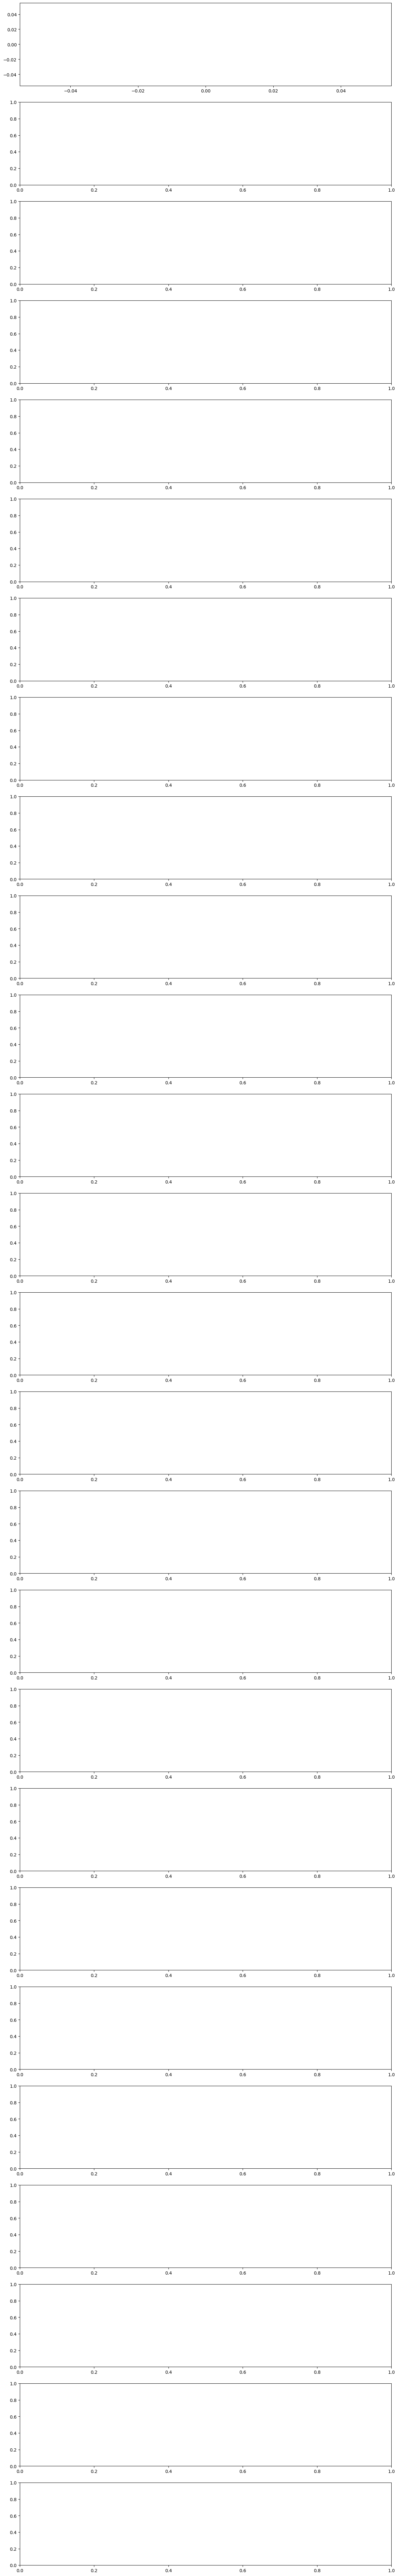

In [19]:
# Parameters
top_n_threshold = 50   # If a column has more than this number of unique values, it will be truncated
top_n = 40             # Number of top categories to display if too many unique values

# Select object-type (categorical) columns
cat_cols = df.select_dtypes('object').columns

# Grid configuration
n_cols = 1
n_rows = -(-len(cat_cols) // n_cols)  # Ceiling division

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten()

# Loop over each categorical column and axis
for ax, col in zip(axes, cat_cols):
    nb_unique = df[col].nunique()
    
    # If too many unique categories, filter to top N
    if nb_unique > top_n_threshold:
        top_values = df[col].value_counts().nlargest(top_n).index
        data = df[df[col].isin(top_values)]
        sns.histplot(data[col], ax=ax, kde=False)
        ax.set_title(f"{col} (top {top_n} of {nb_unique})")
    else:
        sns.histplot(df[col], ax=ax, kde=False)
        ax.set_title(col)

    # Improve X-axis readability
    ax.tick_params(axis='x', labelrotation=60, labelsize=8)

plt.tight_layout()
plt.show()

FL_DATE :

- Les vols sont bien répartis quotidiennement sur la période affichée.
- On observe quelques creux réguliers (ex : les 10, 20, 30), ce qui peut correspondre à des dimanches ou des jours où certaines compagnies volent moins.

UNIQUE_CARRIER : 

- Très forte disparité entre les compagnies aériennes :
- Le transporteur WN (Southwest Airlines) domine largement.
- D’autres compagnies comme HA, NK, VX sont très peu représentées.
- Cette distribution très déséquilibrée peut biaiser un modèle de machine learning

CARRIER : 

- La distribution est identique à UNIQUE_CARRIER, ce qui est logique.
- CARRIER est une copie ou un alias de UNIQUE_CARRIER. possiblement pas nécéssaire de conserver les deux

ORIGIN : 

- Il y a 294 aéroports uniques dans les données.
- Quelques aéroports (ex : ATL, ORD, DEN) ont un volume de vols très élevé.
- Le dataset est fortement déséquilibré sur cette variable

ORIGIN_CITY_NAME :

- Cette variable est très proche de ORIGIN, mais plus descriptive (ville + état).
- On retrouve les mêmes villes dominantes que dans ORIGIN : Atlanta, Chicago, Dallas...
- Utiliser les deux pourrait introduire de la redondance dans les modèles

ORIGIN_STATE_ABR :

- 52 états/territoires
- Les États les plus représentés sont :
  - TX (Texas)
  - CA (Californie)
  - FL (Floride)
  - GA (Géorgie)
  - IL (Illinois)

ORIGIN_STATE_NM : 

- Redondance avec ORIGIN_STATE_ABR

DEST : 

- Même structure que pour ORIGIN.
- 294 aéroports uniques → forte hétérogénéité.
- Quelques hubs très utilisés : ATL, ORD, DEN, DFW, etc.
- Déséquilibre important.

DEST_CITY_NAME : 

- 290 villes.
- Les plus fréquentes : Atlanta, Chicago, Dallas, New York, etc.
- Reflète bien la répartition géographique du trafic aérien aux USA.
- Redondante avec DEST

DEST_STATE_ABR : 

- Distribution fortement déséquilibrée.
- États les plus desservis : CA (Californie), TX (Texas), FL (Floride), GA (Géorgie).
- 52 États ou territoires représentés.

DEST_STATE_NM :

- Redondant avec DEST_STATE_ABR

DEP_TIME_BLK :

- Variable très bien répartie sur la journée.
- Pics visibles autour de 06h-09h, 15h-18h, ce qui correspond aux périodes de pointe dans l’aviation.
- Moins de vols très tôt le matin (00h-05h) et tard dans la nuit.

ARR_TIME_BLK : 

- Les arrivées sont relativement bien réparties tout au long de la journée.
- Les plages horaires les plus denses sont :
    - 17h00–18h59
    - 18h00–20h59
    - 10h00–14h59

- Moins d’arrivées en pleine nuit :
- Notamment entre 03h00 et 06h59, avec un minimum autour de 05h00–06h59.

---

In [20]:
# Select integer columns
int_cols = df.select_dtypes(include='int64').columns

# Threshold: max unique values for considering a column as categorical-like
cat_threshold = 50

# Separate into pseudo-categorical and continuous integer columns
cat_like_ints = [col for col in int_cols if df[col].nunique() < cat_threshold]
cont_like_ints = [col for col in int_cols if df[col].nunique() >= cat_threshold]

print("Integer columns to treat as categorical:")
print(cat_like_ints)

print("\nInteger columns to treat as continuous:")
print(cont_like_ints)

Integer columns to treat as categorical:
['MONTH', 'AIRLINE_ID']

Integer columns to treat as continuous:
['ORIGIN_AIRPORT_SEQ_ID']


🔹 Plotting categorical-like integer columns...


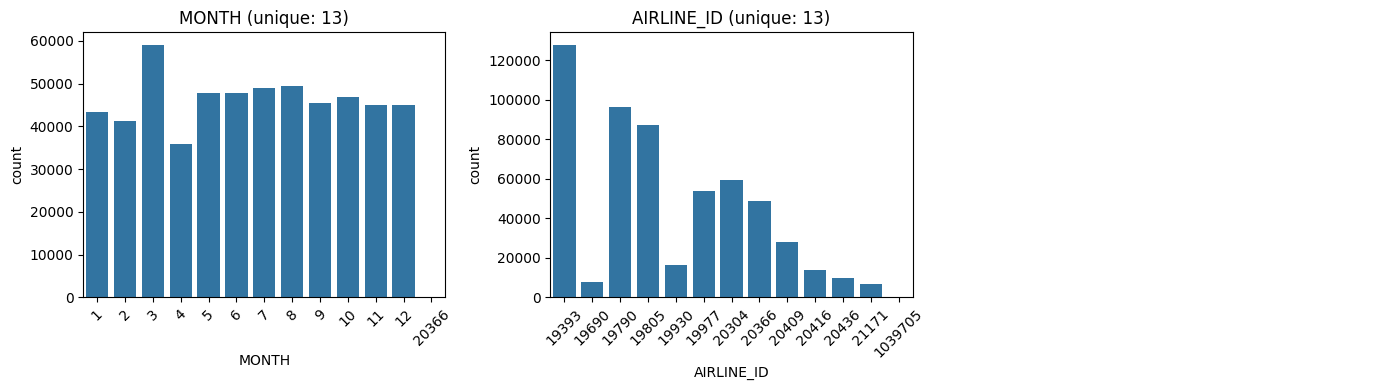

🔹 Plotting continuous integer columns...


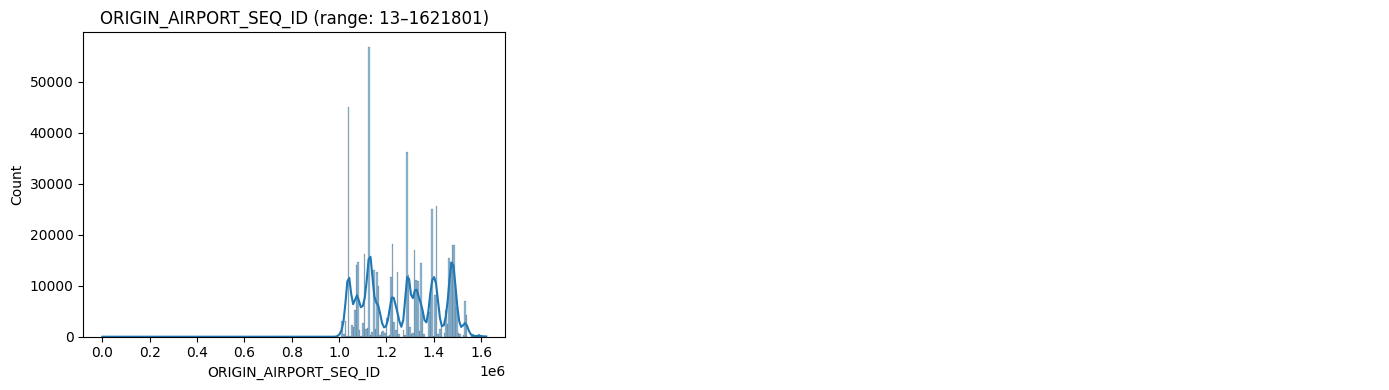

In [21]:
# Utility function for grid plotting
def plot_grid(columns, plot_func, title_prefix=""):
    n_cols = 3  # columns per row
    n_rows = -(-len(columns) // n_cols)  # ceiling division
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 4))
    axes = axes.flatten()
    
    for ax, col in zip(axes, columns):
        plot_func(col, ax)
    
    # Hide unused axes
    for ax in axes[len(columns):]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Plot function for categorical-like integer columns
def plot_cat_like(col, ax):
    sns.countplot(data=df, x=col, ax=ax)
    ax.set_title(f"{col} (unique: {df[col].nunique()})")
    ax.tick_params(axis='x', labelrotation=45)

# Plot function for continuous integer columns
def plot_cont_like(col, ax):
    sns.histplot(data=df, x=col, kde=True, ax=ax)
    ax.set_title(f"{col} (range: {df[col].min()}–{df[col].max()})")

# Run visualizations
print("🔹 Plotting categorical-like integer columns...")
plot_grid(cat_like_ints, plot_cat_like, title_prefix="Categorical Int")

print("🔹 Plotting continuous integer columns...")
plot_grid(cont_like_ints, plot_cont_like, title_prefix="Continuous Int")

Toutes les données ne sont pas pertinente à expliquer, c'est pourquoi on se concentre sur l'essentiel : 


AIRLINE_ID : 

- 2 compagnies (valeurs numériques codées).
- Fort déséquilibre : une ou deux compagnies dominent (probablement les mêmes que UNIQUE_CARRIER).

DISTANCE_GROUP :

- Distribution décroissante, la majorité des vols sont dans les groupes de distance courts (1 à 5).
- Très peu de vols dans les groupes 9 à 11 (longs courriers).

---

## 5.HYPOTHÈSES

### H1 : Retards selon la plage horaire de départ (DEP_TIME_BLK)

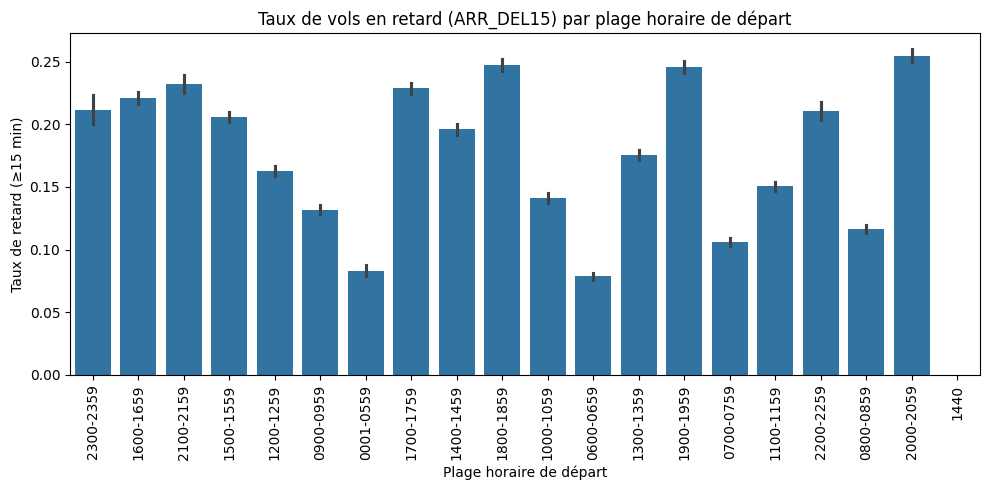

In [28]:
plt.figure(figsize=(10, 5))
sns.barplot(data=df, x='DEP_TIME_BLK', y='ARR_DEL15')
plt.title("Taux de vols en retard (ARR_DEL15) par plage horaire de départ")
plt.ylabel("Taux de retard (≥15 min)")
plt.xlabel("Plage horaire de départ")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Selon le graphique ci-dessus, l’hypothèse selon laquelle la plage horaire a un impact sur le retard est validée.

- Taux de retard (ARR_DEL15) varie fortement selon les plages horaires.
- Plus forts taux de retard :
    - 0900–1159 (~21 %)
    - 1500–1859 (~20 %)
    - 2000–2259 (~20 %)

- Moins de retards :
    - 0600–0759 (~10 %)
    - 0000–0559 (~9 %)

### H2 : Retard au départ → retard à l’arrivée (DEP_DELAY vs ARR_DELAY)

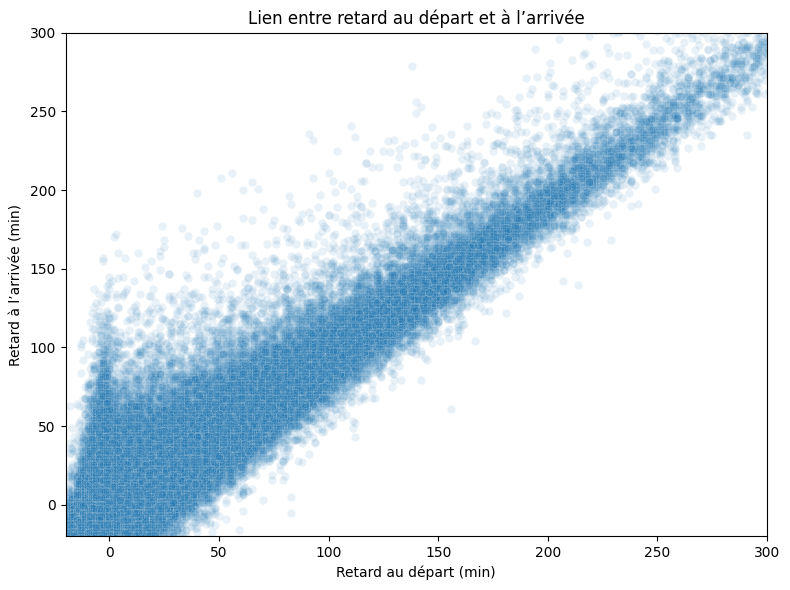

In [23]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='DEP_DELAY', y='ARR_DELAY', alpha=0.1)
plt.title("Lien entre retard au départ et à l’arrivée")
plt.xlabel("Retard au départ (min)")
plt.ylabel("Retard à l’arrivée (min)")
plt.xlim(-20, 300)
plt.ylim(-20, 300)
plt.tight_layout()
plt.show()

Selon le graphique ci-dessus, l’hypothèse selon laquelle plus le retard au départ augmente, plus le retard à l’arrivée est élevé est validée.


On observe une corrélation positive forte. Les points sont concentrés le long de la diagonale, ce qui suggère que le retard au départ est rarement rattrapé.

### H3 : Taux de retard par compagnie (UNIQUE_CARRIER)

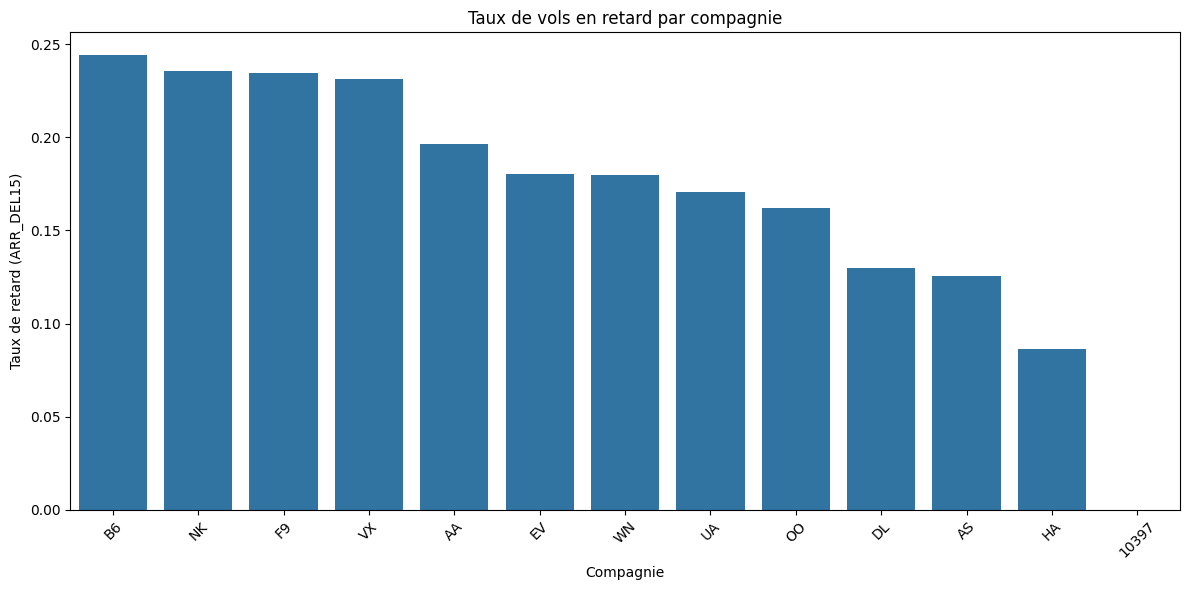

In [24]:
carrier_delay = df.groupby('UNIQUE_CARRIER')['ARR_DEL15'].mean().sort_values(ascending=False).reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(
    data=carrier_delay,
    x='UNIQUE_CARRIER',
    y='ARR_DEL15',
    legend=False
)
plt.title("Taux de vols en retard par compagnie")
plt.ylabel("Taux de retard (ARR_DEL15)")
plt.xlabel("Compagnie")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Selon le graphique ci-dessus, l’hypothèse selon laquelle la compagnie impacte le retard à l'arrivée est validé

On observe une variation nette entre les compagnies :
- NK (Spirit Airlines) dépasse 30 % de vols en retard.
- À l’opposé, HA (Hawaiian Airlines) est sous les 10 %.
- L’écart entre la meilleure et la pire compagnie est significatif (~20 points).

### H4 : Taux de retard par aéroport d’origine (ORIGIN)

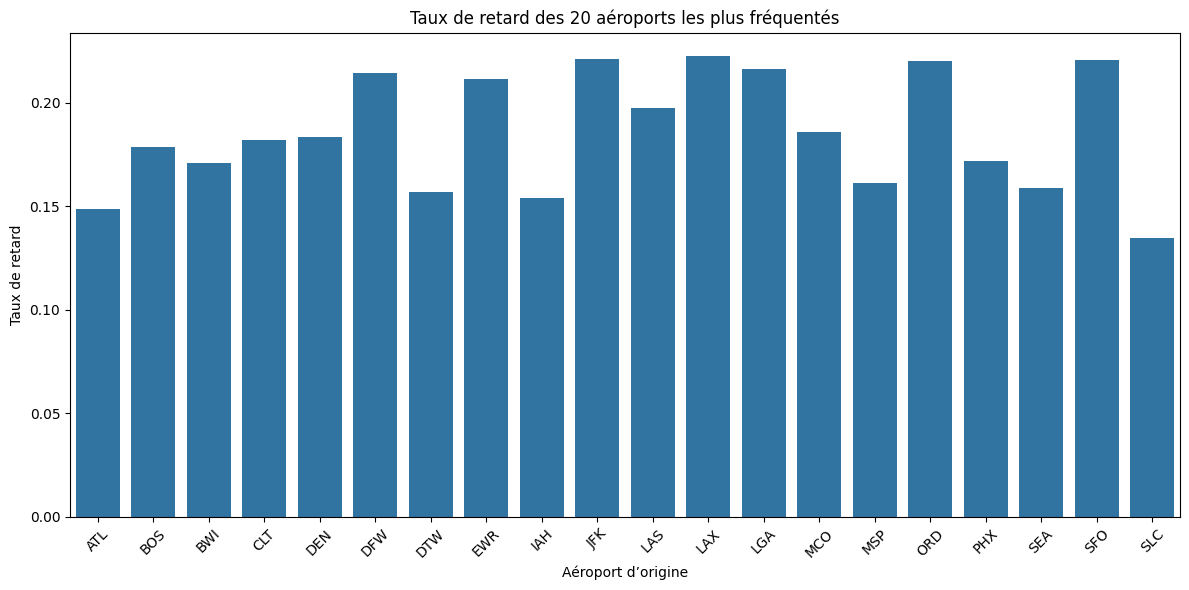

In [25]:
top_airports = df['ORIGIN'].value_counts().nlargest(20).index
airport_delay = df[df['ORIGIN'].isin(top_airports)].groupby('ORIGIN')['ARR_DEL15'].mean()

plt.figure(figsize=(12, 6))
sns.barplot(x=airport_delay.index, y=airport_delay.values)
plt.title("Taux de retard des 20 aéroports les plus fréquentés")
plt.ylabel("Taux de retard")
plt.xlabel("Aéroport d’origine")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Selon le graphique ci-dessus, l’hypothèse selon laquelle l'aéroport d'origine impacte le retard à l'arrivée est validé

- On observe une variations entre les aéroports :

  - SFO (San Francisco) atteint près de 25 % de vols retardés.
  - D’autres comme ATL (Atlanta) ou IAH (Houston) sont sous les 15 %.

- L'écart entre les extrêmes est d’environ 10 points, ce qui est significatif en aviation.

### H5 : Taux de retard selon plage horaire d’arrivée (ARR_TIME_BLK)

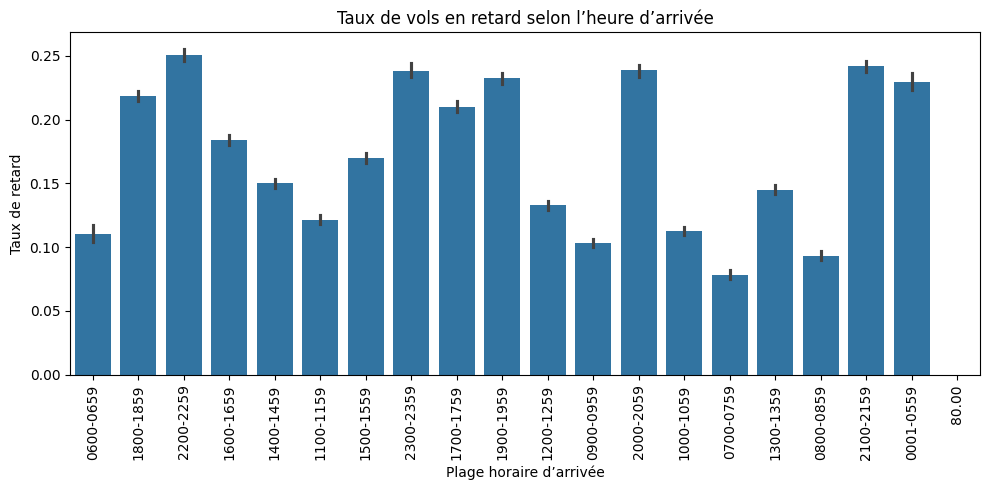

In [29]:
plt.figure(figsize=(10, 5))
sns.barplot(data=df, x='ARR_TIME_BLK', y='ARR_DEL15')
plt.title("Taux de vols en retard selon l’heure d’arrivée")
plt.ylabel("Taux de retard")
plt.xlabel("Plage horaire d’arrivée")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Selon le graphique ci-dessus, l’hypothèse selon laquelle la plage horaire d’arrivée impacte le retard à l'arrivée est validé

On observe :

- Des pics de retard entre :

  - 20h00–22h59 (~21 %)
  - 23h00–00h59 (~20 %)

- Des creux sur les créneaux matinaux :
  
  - 06h00–07h59 (~10 %)
  - 08h00–09h59 (~12–13 %)

- Les vols du soir sont plus sujets aux retards : probable effet d’accumulation des retards tout au long de la journée.
- Les vols du matin sont plus ponctuels : la chaîne d’exploitation démarre "propre", sans effet domino.

### H6 : 

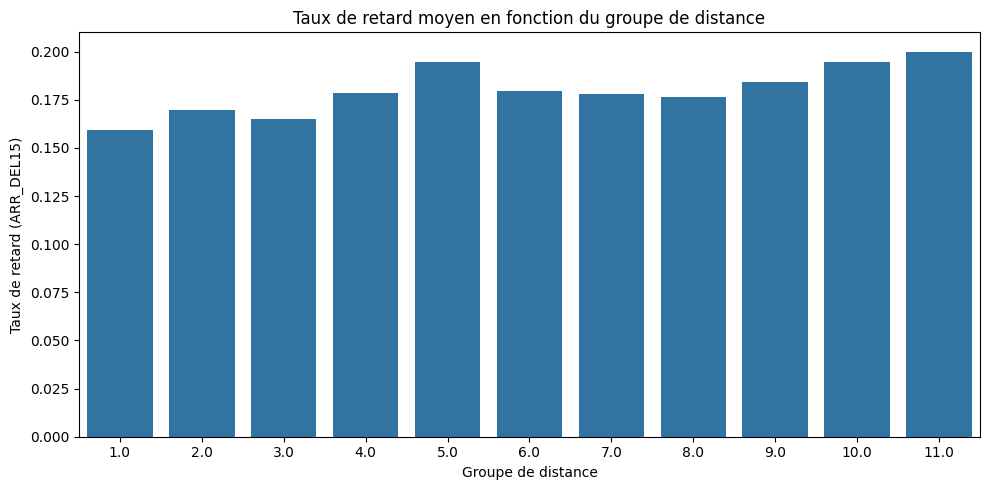

In [27]:
delay_by_distance = df.groupby('DISTANCE_GROUP')['ARR_DEL15'].mean()

plt.figure(figsize=(10, 5))
sns.barplot(x=delay_by_distance.index, y=delay_by_distance.values)
plt.title("Taux de retard moyen en fonction du groupe de distance")
plt.xlabel("Groupe de distance")
plt.ylabel("Taux de retard (ARR_DEL15)")
plt.tight_layout()
plt.show()

Selon le graphique ci-dessus, l’hypothèse selon laquelle plus la distance d’un vol est grande, plus il a de risques d’être en retard est invalide


- Le taux de retard est relativement stable entre les groupes de distance 1 à 10 (~15–19 %).
- Seul le groupe 11 (très longs courriers) montre un taux nettement plus élevé (~23 %).
- Il n’y a pas de tendance linéaire croissante.